In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Resistor values (Ohm)
R_1 = 100
R_2 = 20E3
R_3 = 47E3
R_4 = 200
R_5 = 2E3

# Capacitor values (F)
C_1 = 680E-12
C_2 = 0.22E-6
C_3 = 1E-9

def Z_c(C, f):
    """
    Capacitor impedance
    """
    
    return 1 / (2 * np.pi * f * C * complex(0, 1))


def VDG(Z_1, Z_2):
    """
    Gain factor for voltage divider Op-amp circuit
    """

    return (Z_1 + Z_2) / Z_1


def VDF(Z_1, Z_2):
    """
    Voltage divider circuit gain factor
    """

    return Z_1 / (Z_2 + Z_1)


def c_amp(f):
    """
    Final complex amplification factor for entire circuit
    """
    
    return VDG(R_1, 1/(1/R_2 + 1/Z_c(C_1, f))) * VDF(R_3, Z_c(C_2, f)) * VDG(R_4, 1/(1/R_5 + 1/Z_c(C_3, f)))


def amplification(c_amp):
    """
    Converts complex amplification factor to real amplification factor
    """
    
    return np.sqrt(c_amp * c_amp.conjugate())

def phase(c_amp):
    """
    Converts complex amplification factor to phase shift
    """

    # c_amp lies in Q1 of complex plane
    if c_amp.real >= 0 and c_amp.imag >= 0:
        return np.arctan(c_amp.imag / c_amp.real)
    
    # c_amp lies in Q2 of complex plane
    elif c_amp.real < 0 and c_amp.imag >= 0:
        return -np.pi + np.arctan(c_amp.imag / c_amp.real)
   
    # c_amp lies in Q3 of complex plane
    elif c_amp.real < 0 and c_amp.imag < 0:
        return np.arctan(c_amp.imag / c_amp.real) - np.pi

    # c_amp lies in Q4 of complex plane
    else:
        return np.arctan(c_amp.imag / c_amp.real)

c:\Users\logan\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Frequency (Hz)')

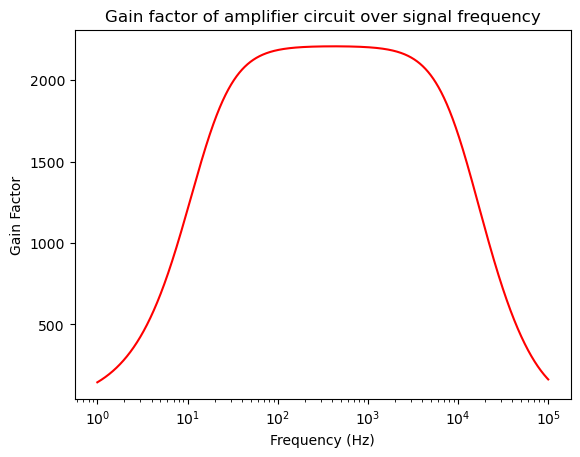

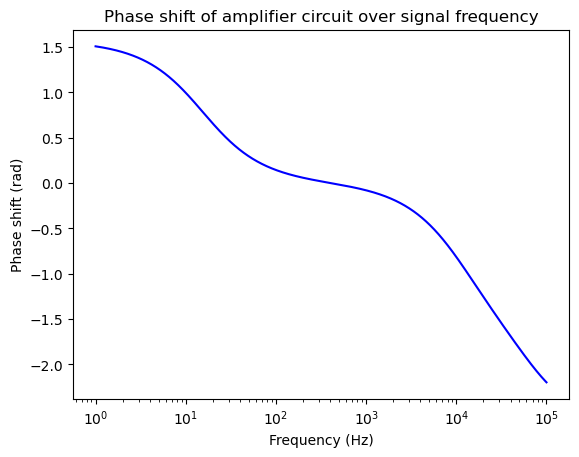

In [25]:
f_arr = np.logspace(0, 5, 5000)

amp_arr = []
phase_arr = []

for f in f_arr:
    amp_arr.append(amplification(c_amp(f)))
    phase_arr.append(phase(c_amp(f)))

fig0 = plt.figure(0)
ax0 = fig0.add_subplot()
ax0.set_xscale('log')
ax0.plot(f_arr, amp_arr, 'r')
ax0.set_title('Gain factor of amplifier circuit over signal frequency')
ax0.set_ylabel('Gain Factor')
ax0.set_xlabel('Frequency (Hz)')

fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.set_xscale('log')
ax1.plot(f_arr, phase_arr, 'b')
ax1.set_title('Phase shift of amplifier circuit over signal frequency')
ax1.set_ylabel('Phase shift (rad)')
ax1.set_xlabel('Frequency (Hz)')